# Prediction Mechanism 

## Import all relevant libraries and data

#### We will be using the following libraries in this task:

- Pandas: Pandas is the most widely used data storage and manipulation library. We import, store, process and save our data in the form of Pandas DataFrames.


- NumPy: Numpy is the python library to store and form n-dimensional arrays which are used to build, train and test machine learning models.


- Matplotlib and Seaborn: These two libraries are used for data visualization. Matplotlib makes graphs of all sorts, and seaborn is an extension to it to make graphs more visually appealing.


- SciKitLearn: SKlearn is a data preprocessing library which we would use for train test splits and data scaling.


- Tensorflow and Keras: Tensorflow is the most powerful library for deep learning tasks with built in methods to train and test models. Keras is a high-level Tensorflow API to build and run deep learning models with ease and lesser code.


In [1]:
!pip install pandas
!pip install seaborn
!pip install keras
!pip install sklearn

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.optimizers import Adam
from keras.utils import plot_model
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler

## Data Visualization

#### A file is chosen as a sample. The code is generalized for all such files.

In [3]:
abl = pd.read_csv('Input/ABL PA Equity.csv') 
abl.tail()

,Date,Open,High,Low,Close,Volume
3947,2020-10-02,87.01,87.50,86.00,86.00,8000.0
3948,2020-10-05,86.99,92.44,81.04,83.83,63500.0
3949,2020-10-06,83.11,85.47,83.00,83.00,50000.0
3950,2020-10-07,82.60,84.35,82.50,82.94,37500.0
3951,2020-10-08,82.91,89.16,82.36,86.73,79000.0


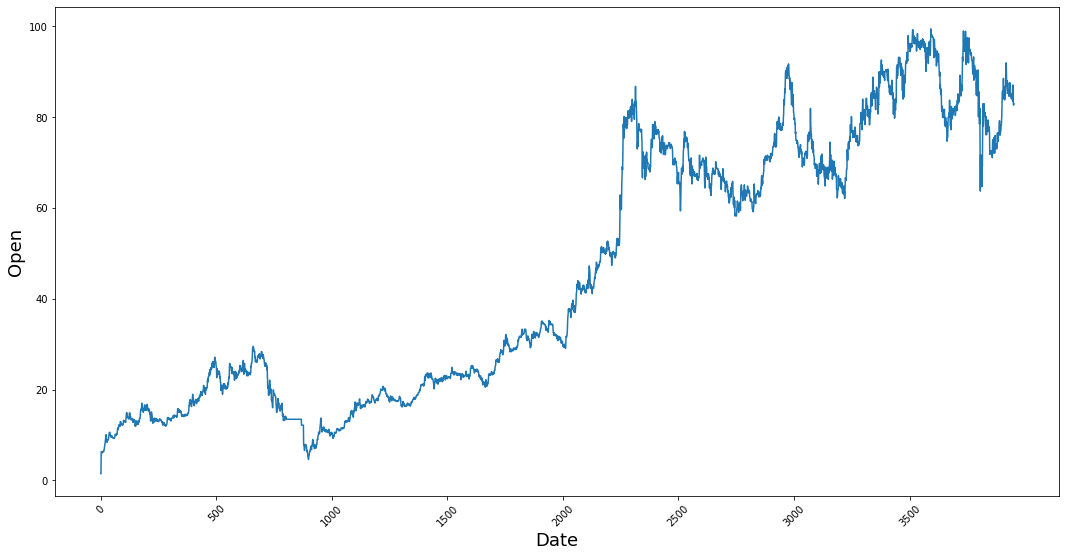

In [6]:
plt.figure(figsize = (18,9))
plt.plot(range(abl.shape[0]), abl['Open'])
plt.xticks(range(0, abl.shape[0], 500), rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open', fontsize=18)
plt.show()

# Test-Train-Validation Split

#### The data is split into 3 parts. 

#### The first is the train part where we provide the model real prices as input and labels. It analyses the prices and attempts to predict the next day price. When predicted, the actual price for that day is given so it can learn accordingly.

#### The second is the test part, where we provide the model data it has not seen before and ask it to predict using this new data entirely.

#### The third part is the validation part. We keep some data never shown to the model in train and test parts and then ask it to predict this without ever seeing it.

In [20]:
def test_train_split(df, column):

    prices = df[column] #We choose to predict the price of the given column

    # 80-20 split into Train-Test

    train_data = prices[:int(len(prices)*0.7)]
    test_data = prices[int(len(prices)*0.7):int(len(prices)*0.8)]
    val_data = prices[int(len(prices)*0.8):]
    
    #Convert to ndarray

    train_data = np.asarray(train_data)
    test_data = np.asarray(test_data)
    val_data = np.asarray(val_data)
    
    #Transform data
    
    train_data = train_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)
    val_data = val_data.reshape(-1, 1)
    
    return train_data, test_data, val_data
        
train_data, test_data, val_data = test_train_split(abl, 'Open')
print(train_data.shape[0])
print(test_data.shape[0])
print(val_data.shape[0])

2766
395
791


## Check distribution of data with scaling

#### A recurrent neural network works better when data is squished between a limit. We want to see if scaling our data this way has any change on its distribution. 

{'whiskers': [<matplotlib.lines.Line2D at 0x22d96421730>,
 'caps': [<matplotlib.lines.Line2D at 0x22d96421e50>,
 'boxes': [<matplotlib.patches.PathPatch at 0x22d96421370>],
 'medians': [<matplotlib.lines.Line2D at 0x22d9642d5b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22d9642d940>],
 'means': []}

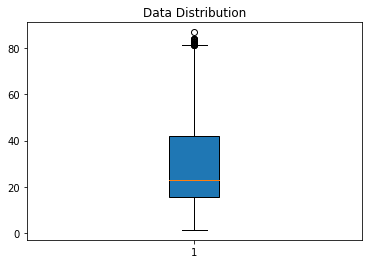

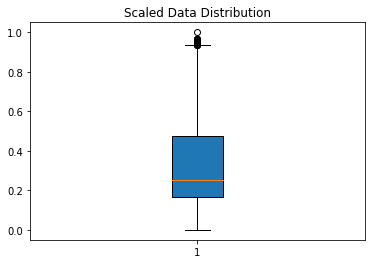

In [8]:
fig1, ax1 = plt.subplots()
ax1.set_title('Data Distribution')
ax1.boxplot(train_data, patch_artist=True)

tempScaler = MinMaxScaler()
scaled_data = tempScaler.fit_transform(train_data)

fig1, ax1 = plt.subplots()
ax1.set_title('Scaled Data Distribution')
ax1.boxplot(scaled_data, patch_artist=True)

#### We can see scaling our data does not change the distribution

## Prepare Train set

#### The data is prepared with the following methodology:

#### We take a window (set of days) to analyze the recent stock movemement. Based on that analysis, and the weight of historical learning (previous analyses), a prediction for  the window+1 day is made. The model compares the predicted price with the original price and adjusts its parameters. This is done iteratively, with a step of window+1 in each iteration. 

#### For example, for a window of 5, the model would look at day 1 to day 5 and predict day 6. Once day 6 is predicted, it would adjust parameters and then move onto the next window of day 7 to day 11 and predict day 12 and so on.

#### The days in the window are stored in x_train (the features). The days to be predicted are stored in y_train (labels). This results in two arrays, x_train and y_train which we would feed into the model

In [22]:
def train_prep(train_data, window, itr):
    scaler = MinMaxScaler((0, 1))
    scaled_train_data = scaler.fit_transform(train_data)

    x_train = [] #Features
    y_train = [] #Labels

    for i in range(window+itr, train_data.shape[0], window+1): #Make windows of 60 days for training until last day

        x_train.append(train_data[i-window:i]) #n day window to look back
        y_train.append(train_data[i:i+1, 0]) #predict for specified days

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
        
    return x_train, y_train, scaler.scale_

x_train, y_train, scale_train = train_prep(train_data, 5, 0)
print(x_train.size, y_train.size)

2305 461


## Prepare test and validation set

#### Exactly the same way as train set, we will make the test set. The only difference is that the test set takes the last window from the train set so it can predict in continuation. 

In [23]:
def test_prep(test_data, train_data, window, itr):
    scaler = MinMaxScaler((0, 1))
    test_data = np.concatenate((train_data[:window], test_data), axis = 0) #Add last previous observations of train data to test
    scaled_test_data = scaler.fit_transform(test_data)

    x_test = []
    y_test = []

    for i in range(window+itr, test_data.shape[0], window+1):
        x_test.append(test_data[i-window:i])
        y_test.append(test_data[i:i+1, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    return x_test, y_test, scaler.scale_
    
x_test, y_test, test_scale = test_prep(test_data, train_data, 5, 0)
print(x_test.size, y_test.size)

330 66


In [24]:
def val_prep(val_data, test_data, window, itr):
    scaler = MinMaxScaler((0, 1))
    val_data = np.concatenate((test_data[:window], val_data), axis = 0) #Add last previous observations of train data to test
    scaled_val_data = scaler.fit_transform(val_data)

    x_val = []
    y_val = []

    for i in range(window+itr, val_data.shape[0], window+1):
        x_val.append(val_data[i-window:i])
        y_val.append(val_data[i:i+1, 0])

    x_val = np.array(x_val)
    y_val = np.array(y_val)
        
    return x_val, y_val, scaler.scale_
    
x_val, y_val, val_scale = val_prep(val_data, test_data, 5, 0)
print(x_val.size, y_val.size)

660 132


## Building the GRU

#### We chose the GRU model as it performed the best on our problem. The architecture is such that there are two layers of GRU. The first layer takes the input as we defined in train and test sets. It then forwards its results to the second layer which works similarly. Both layers are activated by ReLU on the output to ensure non-linearity of our problem. 

In [12]:
def create_model(x_train, units_1, units_2):

    model = Sequential()

    model.add(GRU(units = units_1, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))

    model.add(GRU(units = units_2, activation = 'relu'))

    model.add(Dense(units = 1))
    
    return model
    
model = create_model(x_train, 16, 32)

model.summary()

plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5, 16)             912       
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                4800      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,745
Trainable params: 5,745
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


#### ADAM is an optimizer used to optimize the Stochastic Gradient Descent used to minimize the error the model makes. Mean Squared Error is the error or loss function used to tell the model how to minimize the error in each step. The number of epochs is defined as how many times the model would need to go through the whole data in order to reach the minimum point of the loss. We have chosen the number at which we are sure the loss becomes constant and does not drop significiantly anymore. The batch size is defined as how many training examples should it put in one batch since the parameters are adjusted after each batch.

In [18]:
def compile_model(model, x_train, y_train, x_test, y_test):

    model.compile(optimizer='adam', loss= 'mean_squared_error')
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data = (x_test, y_test), verbose = 1)
    return history
history = compile_model(model, x_train, y_train, x_test, y_test)

Epoch 1/10
15/15 [==============================] - 0s 22ms/step - loss: 1241.9922 - val_loss: 4123.9185
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 1032.5374 - val_loss: 3327.6414
Epoch 3/10
15/15 [==============================] - 0s 3ms/step - loss: 677.6421 - val_loss: 1398.4373
Epoch 4/10
15/15 [==============================] - 0s 3ms/step - loss: 135.0880 - val_loss: 181.5355
Epoch 5/10
15/15 [==============================] - 0s 3ms/step - loss: 17.0469 - val_loss: 64.3897
Epoch 6/10
15/15 [==============================] - 0s 3ms/step - loss: 3.5888 - val_loss: 49.7220
Epoch 7/10
15/15 [==============================] - 0s 3ms/step - loss: 1.4958 - val_loss: 49.6190
Epoch 8/10
15/15 [==============================] - 0s 3ms/step - loss: 1.0005 - val_loss: 49.8187
Epoch 9/10
15/15 [==============================] - 0s 4ms/step - loss: 0.9721 - val_loss: 49.5609
Epoch 10/10
15/15 [==============================] - 0s 5ms/step - loss: 0.9523 - val_loss

## Testing

#### This is the part where we test our results. y_hat is an array which holds the predictions done on the test dataset we created earlier. After we have y_hat, we revert the scale of data to get original prices once again. These prices are then plotted to closely see how our model is behaving.

In [19]:
y_hat = model.predict(x_test) #Prediction over test set

In [20]:
y_hat_unscaled = y_hat/test_scale[0]
y_test_unscaled = y_test/test_scale[0]

#Scaling back to original values

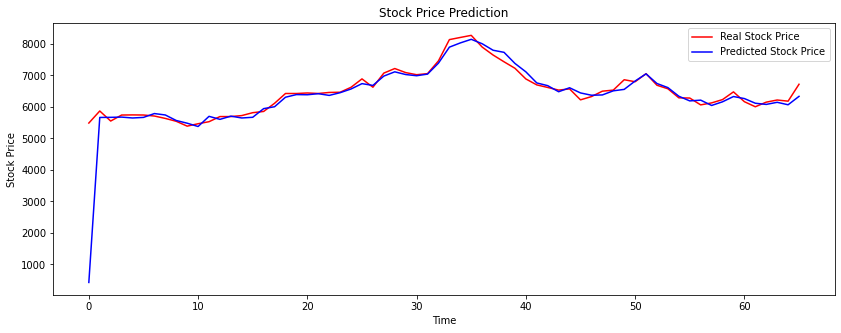

In [21]:
def plot_comparison(y_test, y_hat):

    plt.figure(figsize=(14,5))
    plt.plot(y_test[:], color = 'red', label = 'Real Stock Price')
    plt.plot(y_hat[:], color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
plot_comparison(y_test_unscaled, y_hat_unscaled)

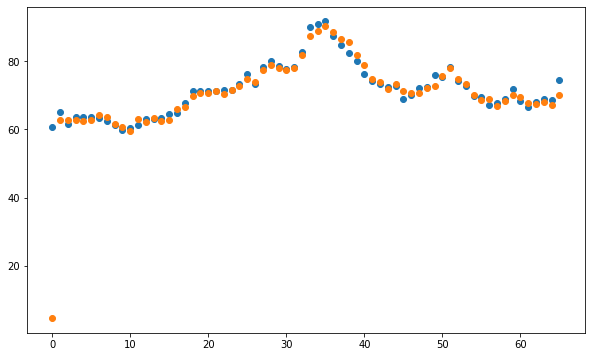

In [22]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
ax.scatter(range(y_test.shape[0]), 
           y_test)

ax.scatter(range(y_test.shape[0]), 
           y_hat)

plt.show()

## Validating


In [23]:
y_hat_val = model.predict(x_val) #Prediction over val set
y_hat_val_unscaled = y_hat_val/val_scale[0]
y_val_unscaled = y_val/val_scale[0]

#Scaling back to original values

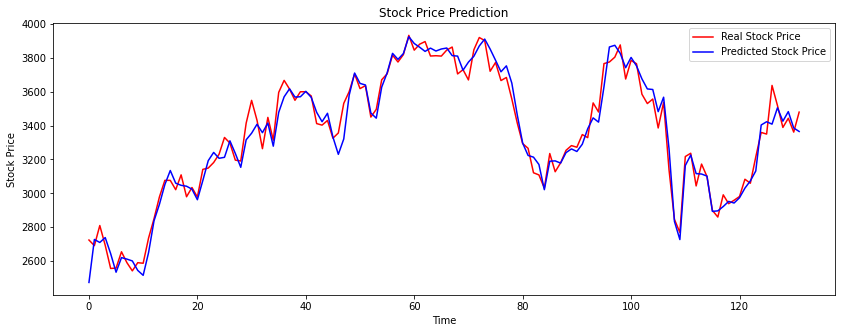

In [24]:
plot_comparison(y_val_unscaled, y_hat_val_unscaled)

In [25]:
mean_acc, lst, summ = [], [], 0,
for i in range(1, len(y_val_unscaled-1)):
    if (y_val_unscaled[i][0] >= y_hat_val_unscaled[i][0]):
        accuracy = (y_hat_val_unscaled[i][0]/y_val_unscaled[i][0])*100
        lst.append(accuracy)
    else:
        accuracy = (y_val_unscaled[i][0]/y_hat_val_unscaled[i][0])*100
        lst.append(accuracy)
for i in lst:
    summ+=i
mean_acc.append(summ/len(lst))
print('Accuracy: ', mean_acc[0],' %')

Accuracy:  98.52775224020672  %


# Pipeline of Module 1

### Running the model on KSE100

In [14]:
KSE100 = pd.read_csv('Input/KSE100.csv')
filtered = KSE100['Ticker'].tolist()
name = []
for i in range(len(filtered)):
    name.append(str(filtered[i]) + ".csv")

In [15]:
a=name[1]
name[1]=name[0]
name[0]=a
print(name)

['UBL PA Equity.csv', 'HBL PA Equity.csv', 'HUBC PA Equity.csv', 'MCB PA Equity.csv', 'OGDC PA Equity.csv', 'LUCK PA Equity.csv', 'ENGRO PA Equity.csv', 'PPL PA Equity.csv', 'FFC PA Equity.csv', 'PSO PA Equity.csv', 'DAWH PA Equity.csv', 'DGKC PA Equity.csv', 'POL PA Equity.csv', 'EFERT PA Equity.csv', 'KAPCO PA Equity.csv', 'NBP PA Equity.csv', 'NESTLE PA Equity.csv', 'SEARL PA Equity.csv', 'BAHL PA Equity.csv', 'FCCL PA Equity.csv', 'MLCF PA Equity.csv', 'KEL PA Equity.csv', 'PSEL PA Equity.csv', 'PIBTL PA Equity.csv', 'PKGS PA Equity.csv', 'NML PA Equity.csv', 'BAFL PA Equity.csv', 'MARI PA Equity.csv', 'PAEL PA Equity.csv', 'FFBL PA Equity.csv', 'KTML PA Equity.csv', 'ABOT PA Equity.csv', 'ABL PA Equity.csv', 'TRG PA Equity.csv', 'EFUG PA Equity.csv', 'FCEPL PA Equity.csv', 'INDU PA Equity.csv', 'NRL PA Equity.csv', 'MUREB PA Equity.csv', 'FATIMA PA Equity.csv', 'HCAR PA Equity.csv', 'NATF PA Equity.csv', 'HASCOL PA Equity.csv', 'PIOC PA Equity.csv', 'HMB PA Equity.csv', 'PAKT PA E

In [25]:
global mean_acc
mean_acc = []
def main(df, column, itre, dates, name):  
    dfs = pd.DataFrame(columns = ['Date', 'Predicted Price'])
    dates1 = dates[int(len(dates)*0.7):]
    dfs['Date'] = dates1
    for itr in range (0,itre):
        train_data, test_data, val_data = test_train_split(df, column)
        x_train, y_train, scale_train = train_prep(train_data, 5, itr)
        x_test, y_test, test_scale = test_prep(test_data, train_data, 5, itr)
        x_val, y_val, val_scale = val_prep(val_data, test_data, 5, itr)
        #model = create_model(x_train, 16, 32)
        #history = compile_model(model, x_train, y_train, x_test, y_test)
        #model.save('Models/'+name[:-4]+'.h5')
        
        ## Uncomment the above 3 lines if you want to run and save the models again
        ## This cell will run itself from using presaved models from Module1/Models
        
        model = tf.keras.models.load_model('Models/'+name[:-4]+'.h5')
        y_hat = model.predict(x_test)
        y_hat_val = model.predict(x_val)
        
        j = int(len(dates)*0.7)+itr
        for i in range(len(y_hat)):
            dfs['Predicted Price'][j] = y_hat[i][0]
            j+=6
        j = int(len(dates)*0.8)+itr
        for i in range(len(y_hat_val)):
            dfs['Predicted Price'][j] = y_hat_val[i][0]
            j+=6
    dfs = dfs.iloc[40:]
    return dfs

def companies(names):
    for i in names:
        print(i)
        df = pd.read_csv('Input/'+i) 
        dates = df['Date']
        dfs = main(df, 'Close', 6, dates, i)
        dfs.to_csv(path_or_buf = 'Output/Predicted/'+i, encoding='utf-8',  sep = ',', index = False) #Save dataframe as CSV
companies(name)

UBL PA Equity.csv
HBL PA Equity.csv
HUBC PA Equity.csv
MCB PA Equity.csv
OGDC PA Equity.csv
LUCK PA Equity.csv
ENGRO PA Equity.csv
PPL PA Equity.csv
FFC PA Equity.csv
PSO PA Equity.csv
DAWH PA Equity.csv
DGKC PA Equity.csv
POL PA Equity.csv
EFERT PA Equity.csv
KAPCO PA Equity.csv
NBP PA Equity.csv
NESTLE PA Equity.csv
SEARL PA Equity.csv
BAHL PA Equity.csv
FCCL PA Equity.csv
MLCF PA Equity.csv
KEL PA Equity.csv
PSEL PA Equity.csv
PIBTL PA Equity.csv
PKGS PA Equity.csv
NML PA Equity.csv
BAFL PA Equity.csv
MARI PA Equity.csv
PAEL PA Equity.csv
FFBL PA Equity.csv
KTML PA Equity.csv
ABOT PA Equity.csv
ABL PA Equity.csv
TRG PA Equity.csv
EFUG PA Equity.csv
FCEPL PA Equity.csv
INDU PA Equity.csv
NRL PA Equity.csv
MUREB PA Equity.csv
FATIMA PA Equity.csv
HCAR PA Equity.csv
NATF PA Equity.csv
HASCOL PA Equity.csv


PIOC PA Equity.csv
HMB PA Equity.csv
PAKT PA Equity.csv
JDWS PA Equity.csv
CHCC PA Equity.csv
KOHC PA Equity.csv
AICL PA Equity.csv
MTL PA Equity.csv
GLAXO PA Equity.csv
THALL PA Equity.csv
ATRL PA Equity.csv
PSMC PA Equity.csv
APL PA Equity.csv
FEROZ PA Equity.csv
NCPL PA Equity.csv
PTC PA Equity.csv
SNGP PA Equity.csv
ISL PA Equity.csv
NPL PA Equity.csv
SSGC PA Equity.csv
IGIHL PA Equity.csv
JLICL PA Equity.csv
ICI PA Equity.csv
SHEL PA Equity.csv
COLG PA Equity.csv
CPPL PA Equity.csv
AKBL PA Equity.csv
SHFA PA Equity.csv
BATA PA Equity.csv
GHGL PA Equity.csv
HGFA PA Equity.csv
SPWL PA Equity.csv
FABL PA Equity.csv
SRVI PA Equity.csv
AHCL PA Equity.csv
DCR PA Equity.csv


BOP PA Equity.csv
PICT PA Equity.csv
JSCL PA Equity.csv
NCL PA Equity.csv
MEBL PA Equity.csv
HUMNL PA Equity.csv
SNBL PA Equity.csv
FML PA Equity.csv
SCBPL PA Equity.csv
JGICL PA Equity.csv
RMPL PA Equity.csv
LPL PA Equity.csv
PKGP PA Equity.csv
EFUL PA Equity.csv
OLPL PA Equity.csv
IDYM PA Equity.csv
ARM PA Equity.csv
IBFL PA Equity.csv
PUNO PA Equity.csv
BNWM PA Equity.csv
ASRL PA Equity.csv


In [26]:
KSE100 = pd.read_csv('Input/KSE100.csv')
filtered = KSE100['Ticker'].tolist()

def predictions_100(filtered):
    
    for i in range(len(filtered)):
        name = filtered[i]
        df = pd.read_csv('Input/'+ name + '.csv')
        df = df.drop(['Date', 'Open', 'High', 'Low', 'Volume'], axis=1)
        predictions = []
        for j in range(14):   
            test_data = np.asarray(df['Close'][-5:])

            test_data = test_data.reshape(1, -1, 1)
            test_data = np.asarray(test_data)

            model = tf.keras.models.load_model('Models/' + name +'.h5')
            y_hat = model.predict(test_data)

            temp = {'Close': y_hat[0][0]}

            predictions.append(y_hat[0][0])
            df = df.append(temp, ignore_index=True)
            
        result = pd.DataFrame(df['Close'][-14:])
        result.to_csv('Output/14 Day/' + name + '.csv')

predictions_100(filtered)

## Joining Predicted Prices with Historic Data

In [29]:
KSE100 = pd.read_csv('Input/KSE100.csv')
filtered = KSE100['Ticker'].tolist()

def predictions_100(filtered):
    
    for i in range(len(filtered)):
        name = filtered[i]
        df = pd.read_csv('Input/'+ name + '.csv')
        df1 = pd.read_csv('Output/Predicted/'+ name + '.csv')
        val_data = df[int(len(df)*0.7)+40:]
        pred_data = df1['Predicted Price'].tolist()
        final = val_data
        final.insert(loc=6, column='Predicted Price', value=pred_data)
        final.to_csv('Output/' + name + '.csv')
    
predictions_100(filtered)

#### Please copy csv files from Module 1/Output to Module 2/Input